In [364]:
import matplotlib.pyplot as plt
import pandas as pd
import json
import os
from pathlib import Path
import numpy as np
import seaborn as sns
import result_handler as rh
from sklearn.metrics import confusion_matrix, f1_score, precision_score, accuracy_score, recall_score



In [365]:
RELOAD_DATA = False
RESULTS_DIR = Path('../translations')
RESULTS_NAME = 'cross_tests_results.csv'

if RELOAD_DATA:
    rh.concatenate_csv_files(RESULTS_DIR, 'predictions.csv', RESULTS_NAME)

df = pd.read_csv(RESULTS_NAME)

In [366]:
grouped = df.groupby(['model_name', 'train_dataset', 'test_dataset'])
normalize = 'true' #Normalize the confusion matrix by row (true) or by column (pred)
def plot_consufion_matrices(grouped: pd.DataFrame, normalize: str = 'true'):
    if normalize == 'true':
        norm = 'by the true labels'
    else:
        norm = 'by the predicted labels'

    for (model, train_ds, test_ds), group in grouped:
        # Compute confusion matrix
        labels = sorted(set(group['label'].unique().tolist() + group['prediction'].unique().tolist()))
        cm = confusion_matrix(group['label'], group['prediction'], labels=labels, normalize=normalize)
        
        # Plot the confusion matrix
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt=".2f", vmin = 0, vmax = 1, cmap='Blues', xticklabels=labels, yticklabels=labels)
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.title(f'Model: {model}\nTrain Dataset: {train_ds}\nTest Dataset: {test_ds}\n Normalized by {norm}', loc = 'left')
        plt.show()


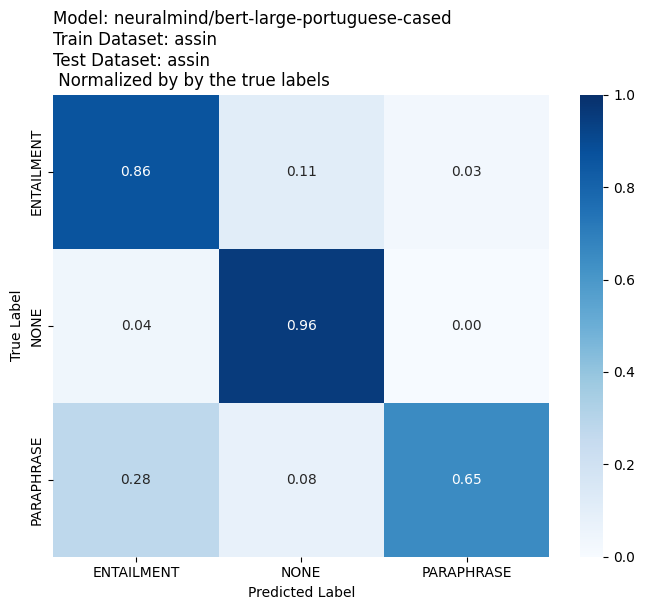

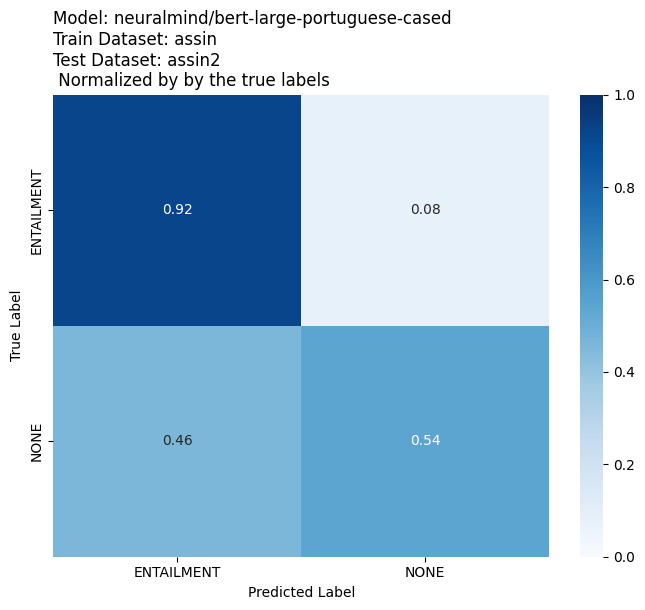

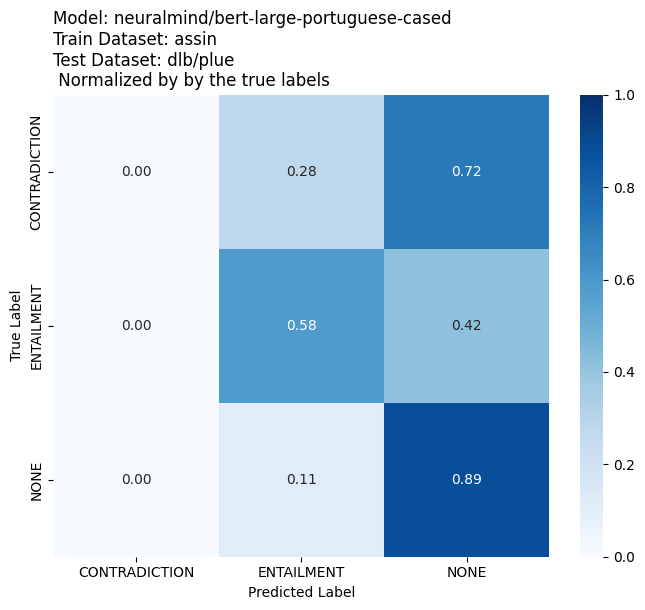

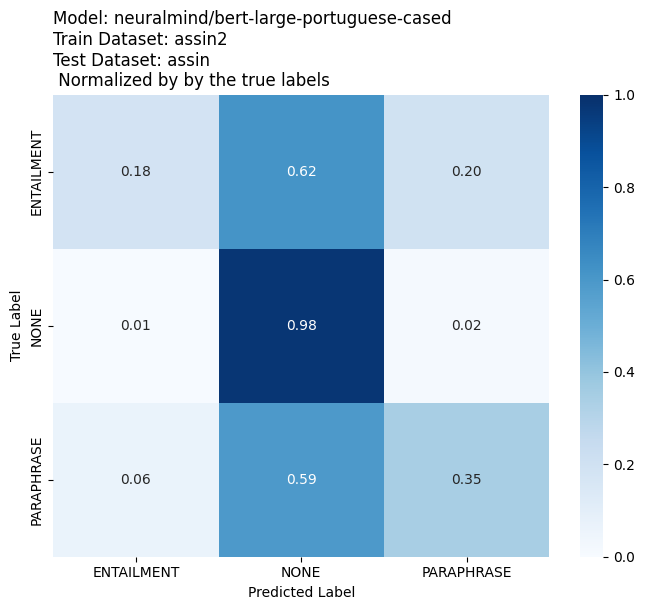

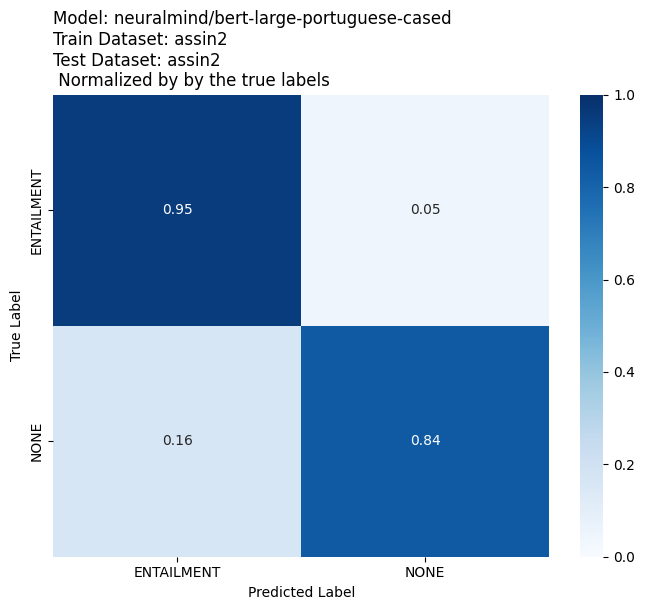

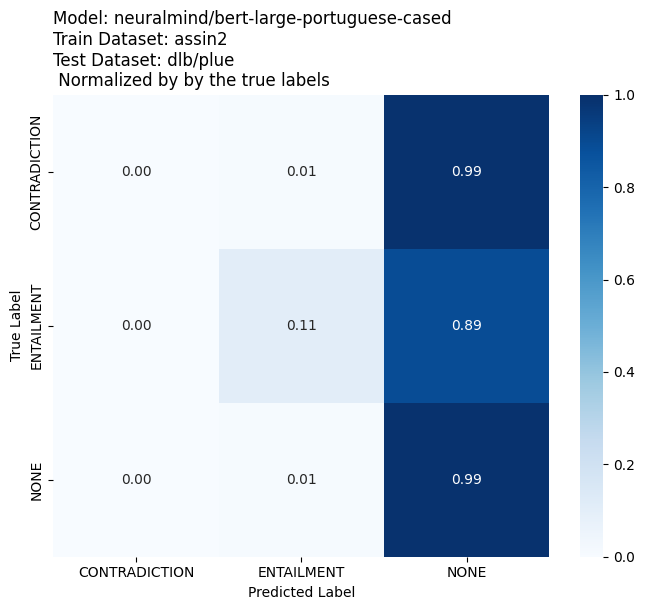

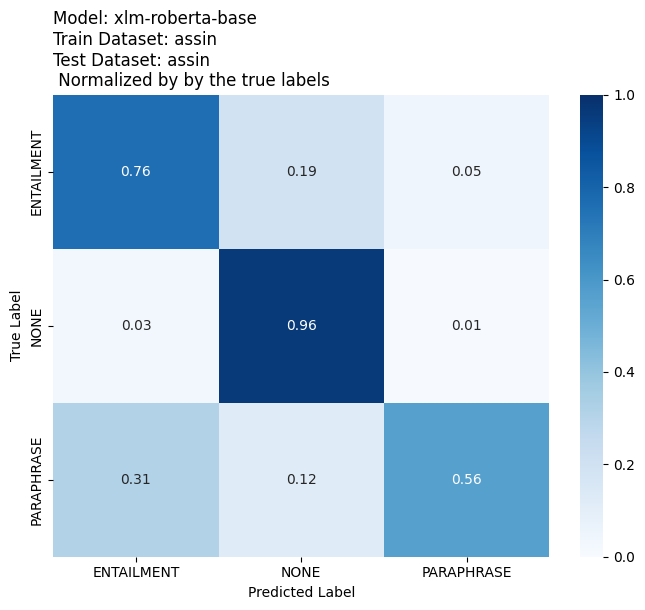

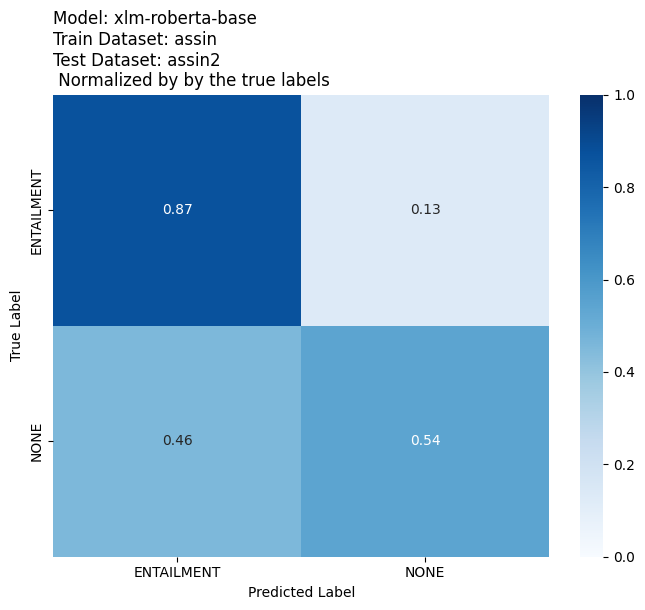

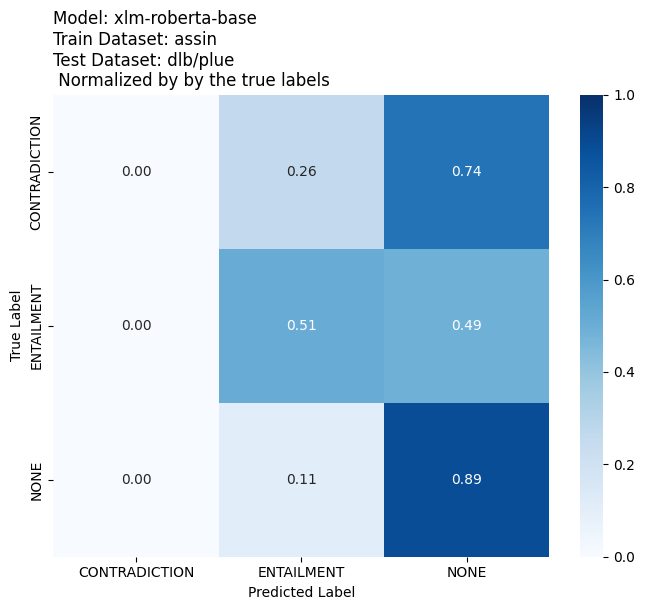

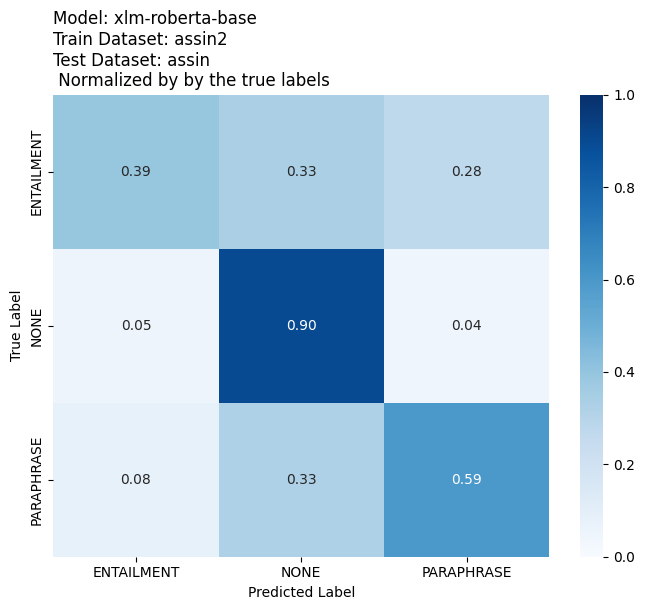

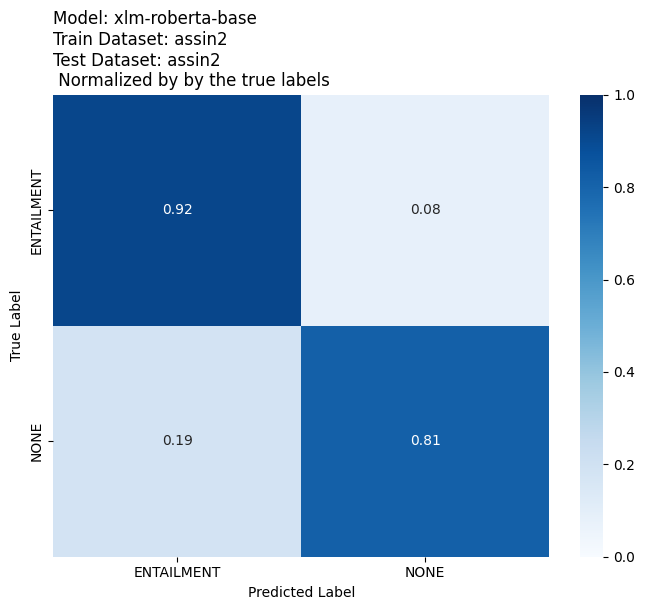

In [367]:
plot_consufion_matrices(grouped, normalize='true')  

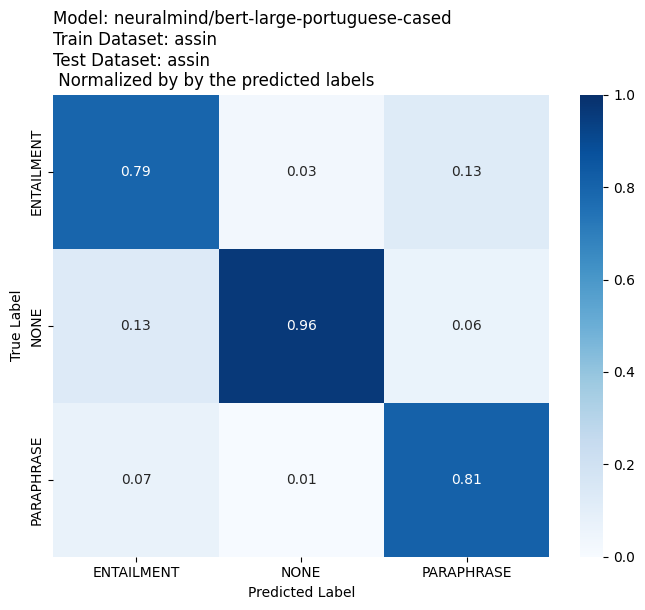

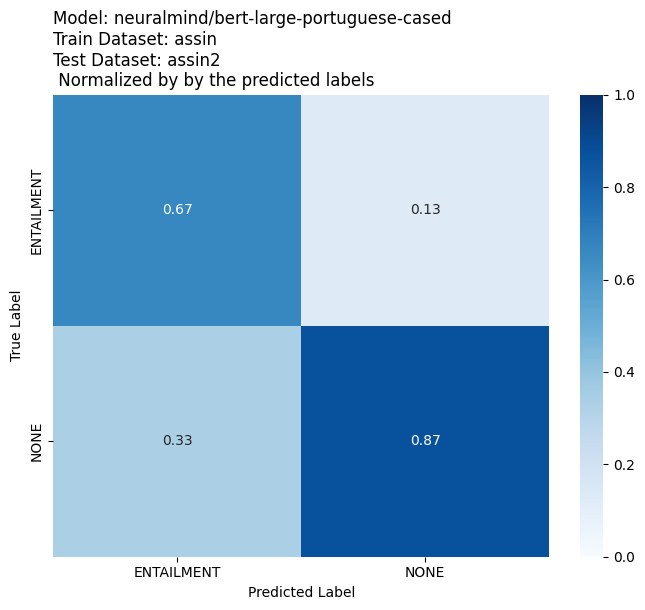

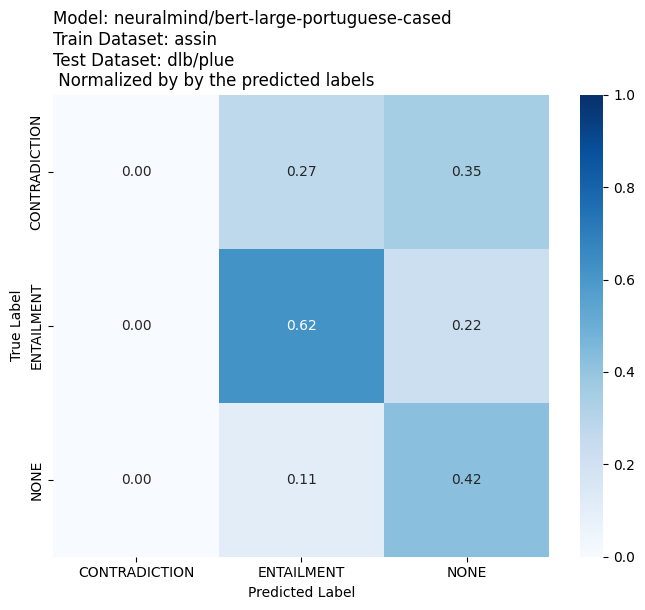

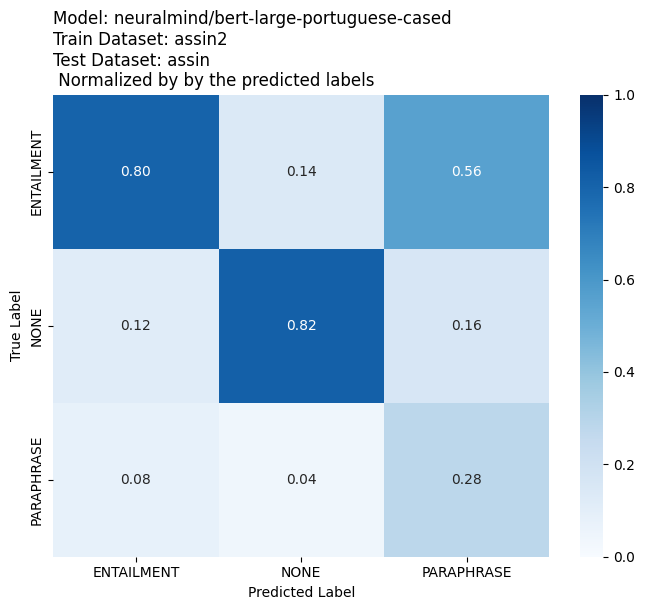

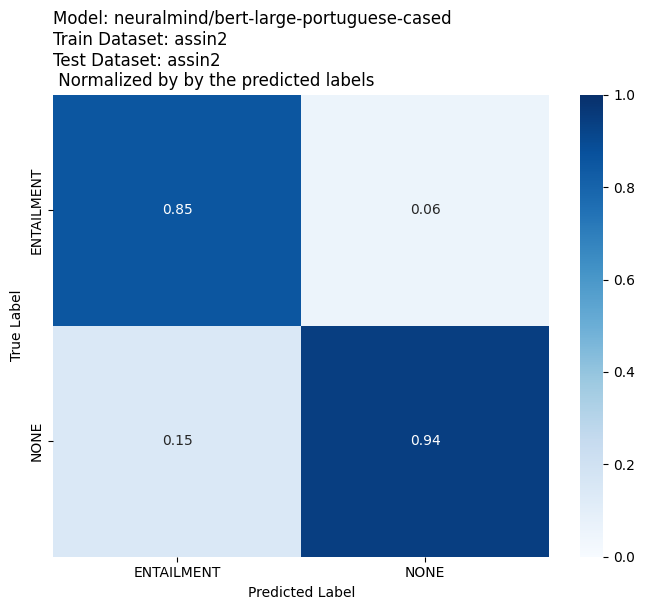

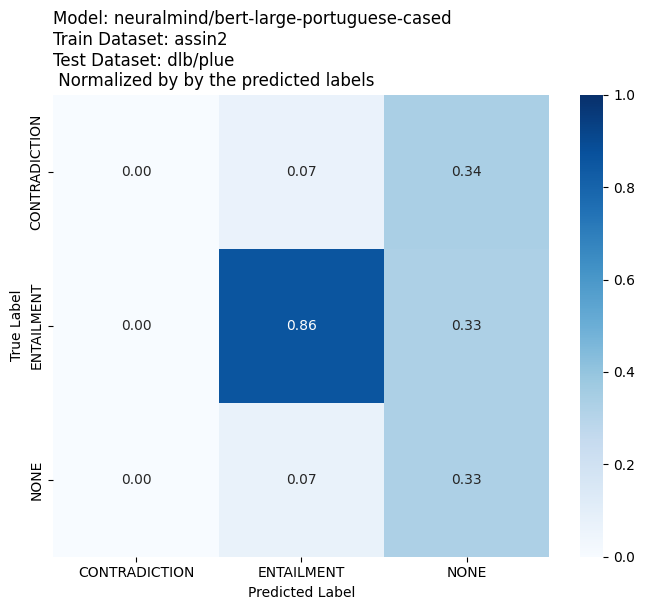

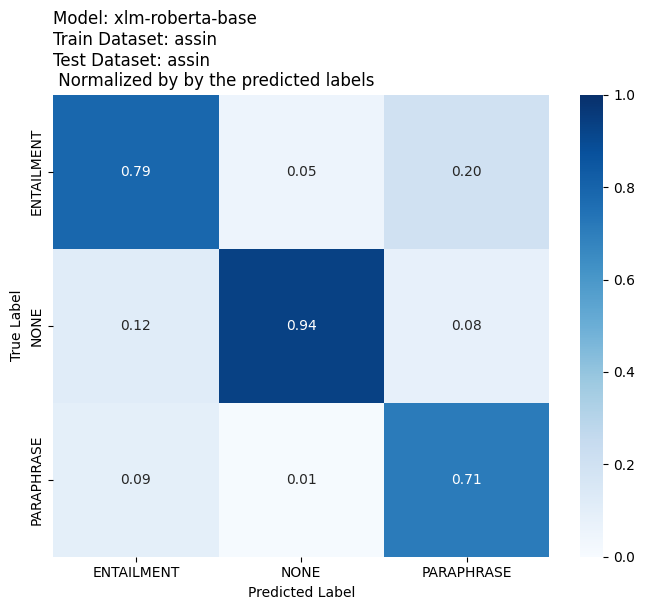

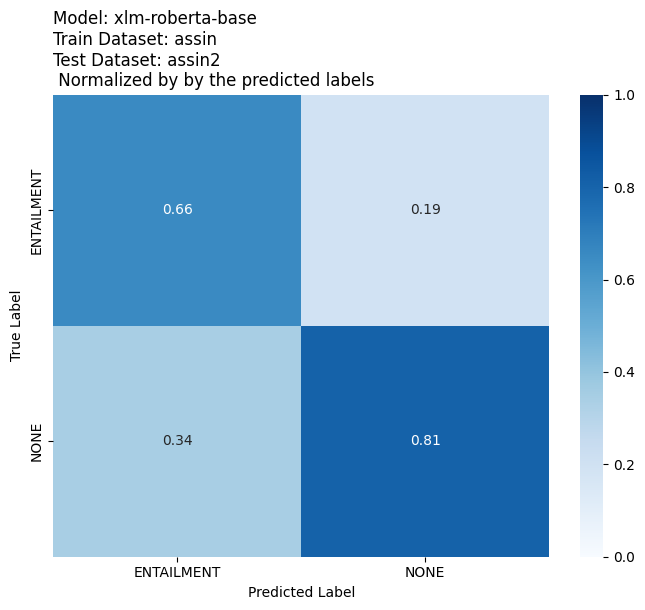

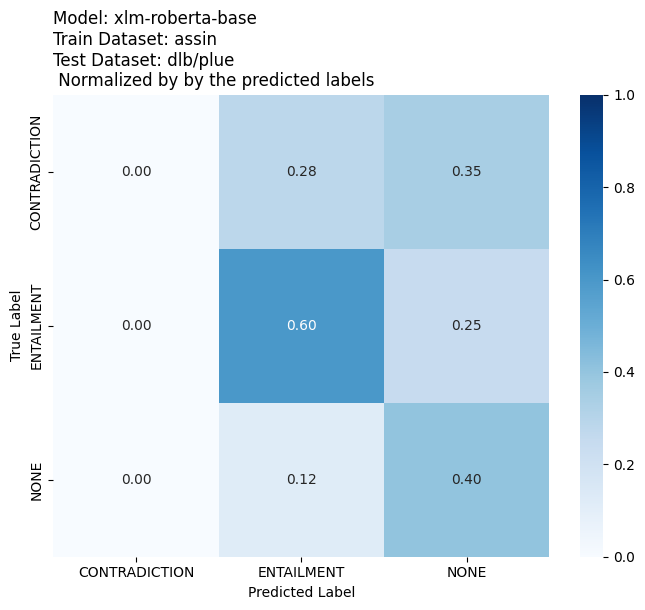

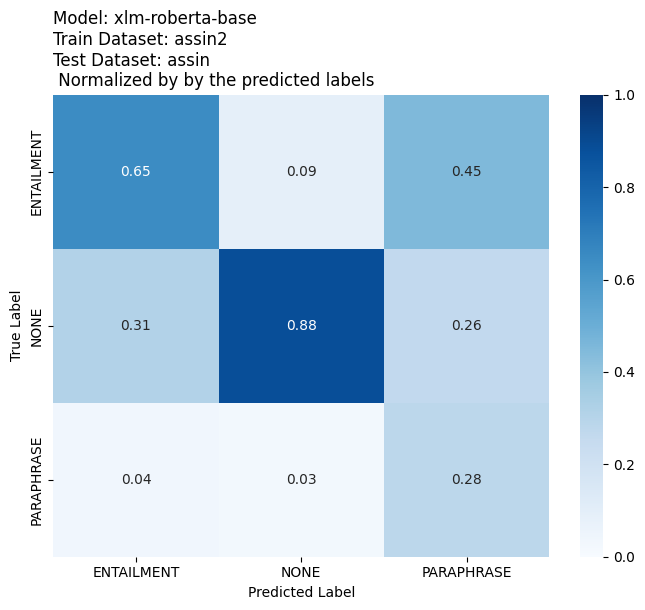

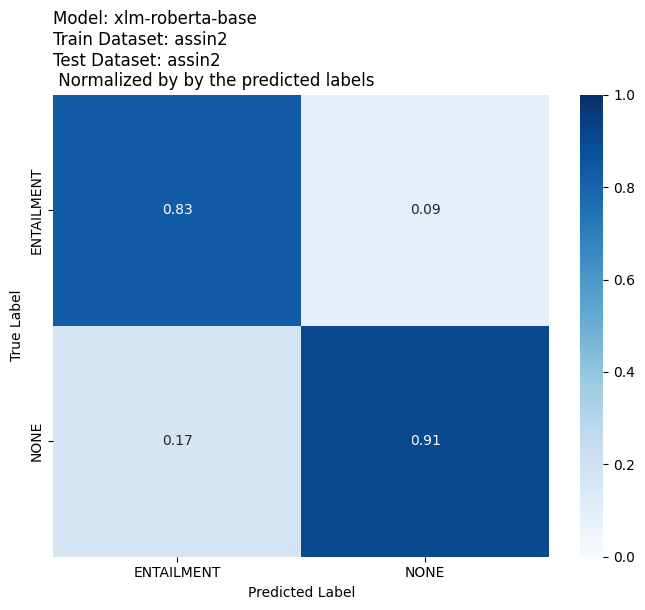

In [368]:
plot_consufion_matrices(grouped, normalize='pred')

In [369]:
def mount_metrics_dataframe(groups: list, df: pd.DataFrame, cols: list) -> pd.DataFrame:
    metrics_data = []
    grouped = df.groupby(groups)

    for columns, group in grouped:
        accuracy = accuracy_score(group['label'], group['prediction'])
        precision = precision_score(group['label'], group['prediction'], average='macro')
        f1 = f1_score(group['label'], group['prediction'], average='macro')
        recall = recall_score(group['label'], group['prediction'], average='macro')
        columns = list(columns)
        columns.extend([accuracy, precision, recall, f1])
        metrics_data.append(columns)
    
    metrics_df = pd.DataFrame(metrics_data, columns=cols)
    return metrics_df




In [370]:
base = ['model_name', 'train_dataset', 'test_dataset']

def add_base_column(base: list, metrics_df: pd.DataFrame, reset_index: bool = False) -> pd.DataFrame:
    new_index = ""
    for b in base:
        new_index += metrics_df[b].astype(str)
    new_col = 'base'
    metrics_df[new_col] = new_index
    metrics_df[new_col] = metrics_df[new_col].apply(hash)
    if reset_index:
        metrics_df.index = metrics_df[new_col]
        metrics_df.drop(columns=new_col, inplace=True)
        metrics_df = metrics_df.reset_index()
    return metrics_df


groups = base.copy()
cols = groups.copy()   
metrics_to_see = ['accuracy', 'f1', 'recall', 'precision']
cols.extend(metrics_to_see)
metrics_df = mount_metrics_dataframe(groups, df, cols)
metrics_df = add_base_column(base, metrics_df)

groups.append('label')
cols = groups.copy()
cols.extend(metrics_to_see)
by_label_metrics_df = mount_metrics_dataframe(groups, df, cols)
by_label_metrics_df = add_base_column(base, by_label_metrics_df, reset_index=False)

labels = df['label'].unique().tolist()
bases = metrics_df['base'].unique().tolist()   
for base in bases:
    row = by_label_metrics_df[by_label_metrics_df['base'] == base]

    for label in labels:
        for metric in metrics_to_see:
            new_col = f'{label}_{metric}'
            val = row[row['label'] == label][metric].tolist()
            if len(val):
                metrics_df.loc[metrics_df['base'] == base, new_col] = val[0]
            else:
                metrics_df.loc[metrics_df['base'] == base, new_col] = 0

metrics_df.to_csv('results.csv', index=False)

/home/giogvn/Natural-Portuguese-Language-Inference/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/giogvn/Natural-Portuguese-Language-Inference/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


/home/giogvn/Natural-Portuguese-Language-Inference/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/giogvn/Natural-Portuguese-Language-Inference/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/giogvn/Natural-Portuguese-Language-Inference/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_s

In [371]:
def plot_metrics_results(metrics_df: pd.DataFrame, model_name: str, metric: str):
    plot = metrics_df[metrics_df['model_name'] == model_name].pivot(index = "train_dataset",
                                                                    columns = "test_dataset",
                                                                    values = metric)
    plt.figure(figsize=(8,6))
    sns.heatmap(plot, annot=True, cmap = 'Blues',fmt=".2f", vmin=0.5, vmax=1)
    plt.title(f"{metric[0].upper() + metric[1:]} for {model_name}")
    plt.show()

In [372]:
def plot_models_benchmark_results(metrics_df: pd.DataFrame, metric: str):
    plot = metrics_df.pivot(index = "test_dataset",columns = "model",values = metric)
    plt.figure(figsize=(8,6))
    sns.heatmap(plot, annot=True, cmap = 'Blues',fmt=".2f", vmin=0.5, vmax=1)
    plt.title(f"Models' {metric} comparison")
    plt.xticks(rotation=90)
    plt.show()

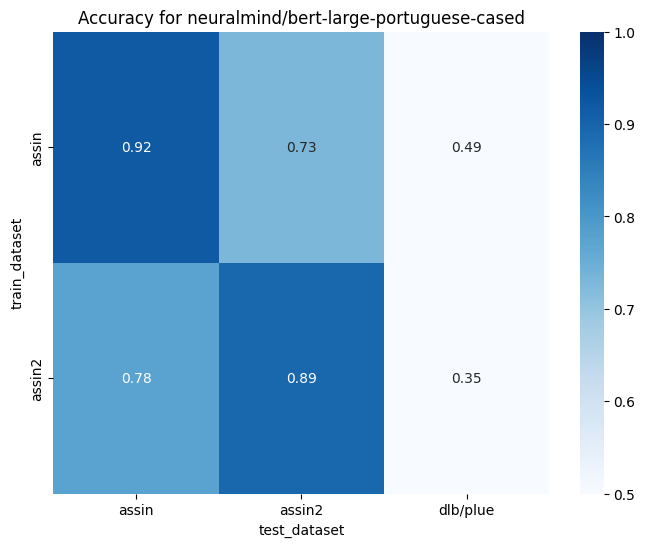

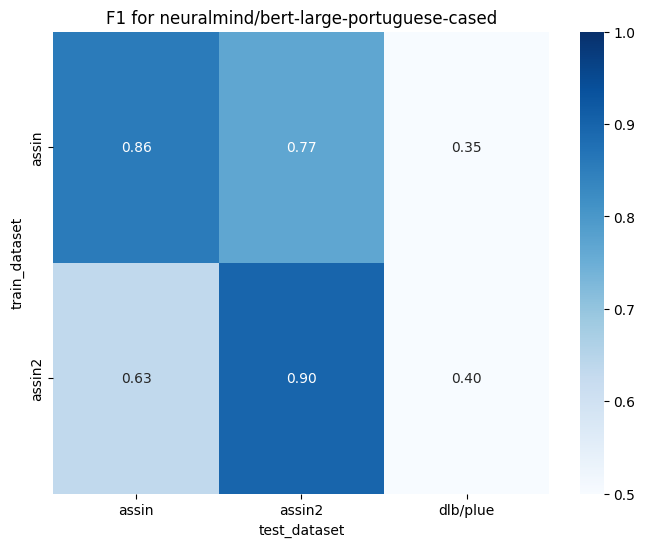

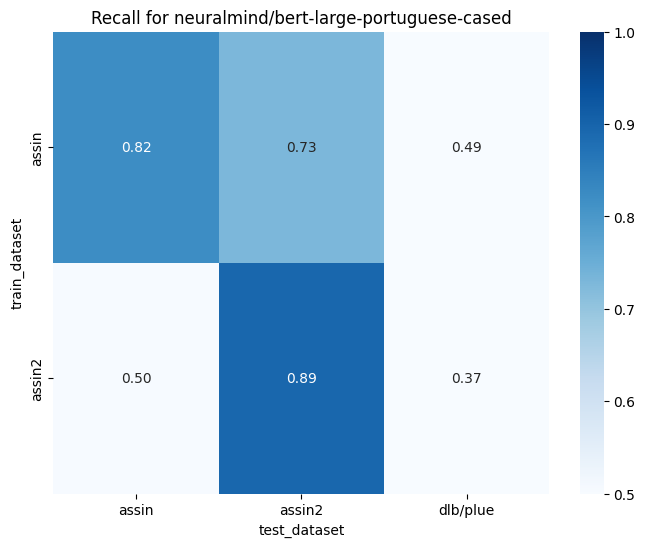

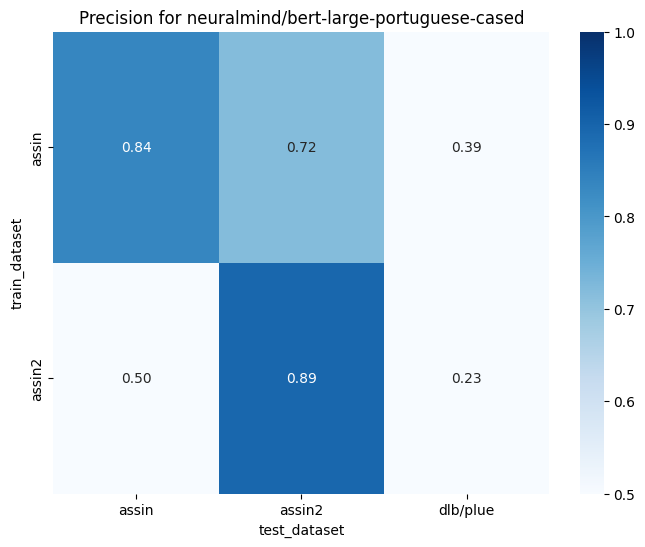

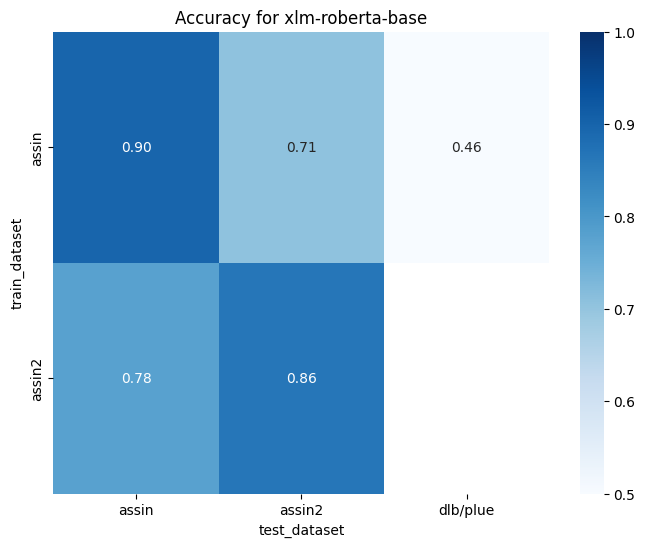

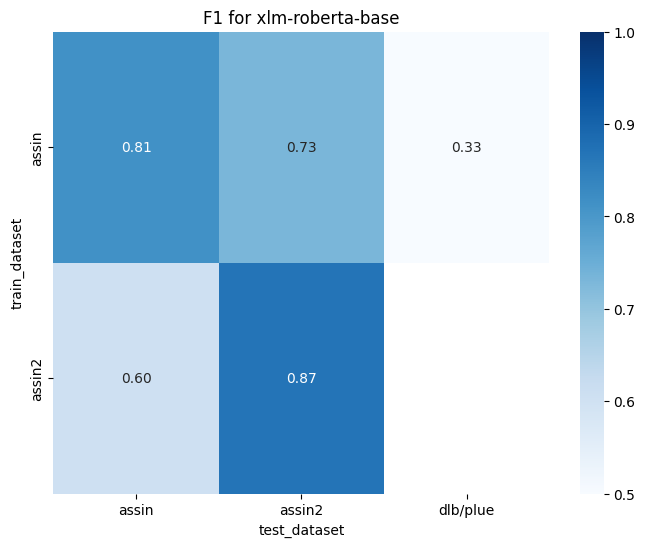

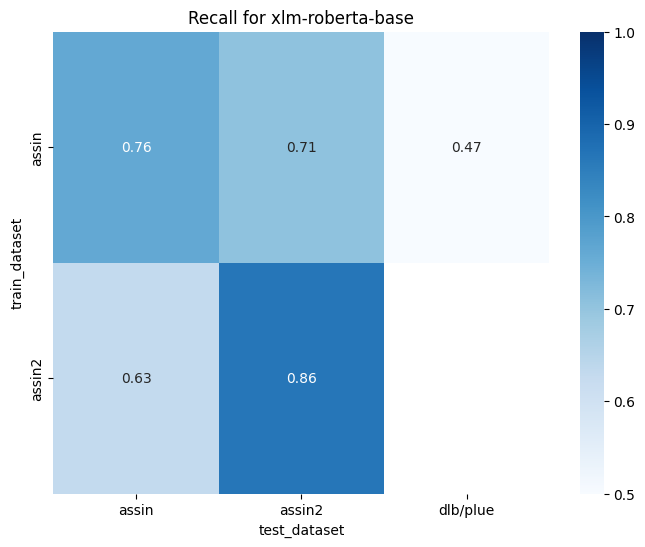

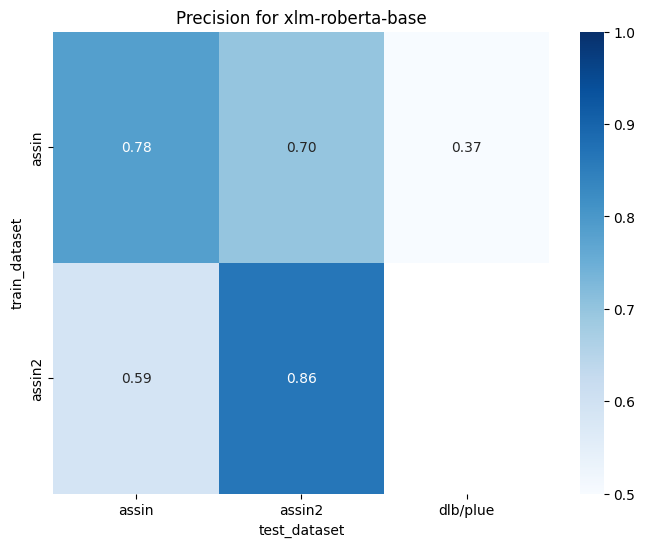

In [373]:
model_names = metrics_df['model_name'].unique()
for model_name in model_names:
    for metric in ['accuracy', 'f1', 'recall', 'precision']:
        plot_metrics_results(metrics_df, model_name, metric)

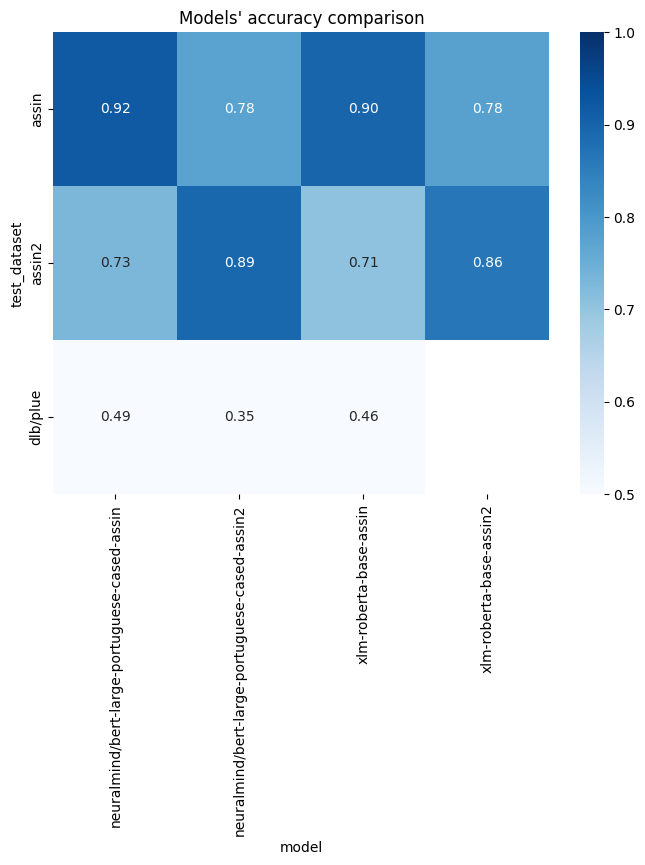

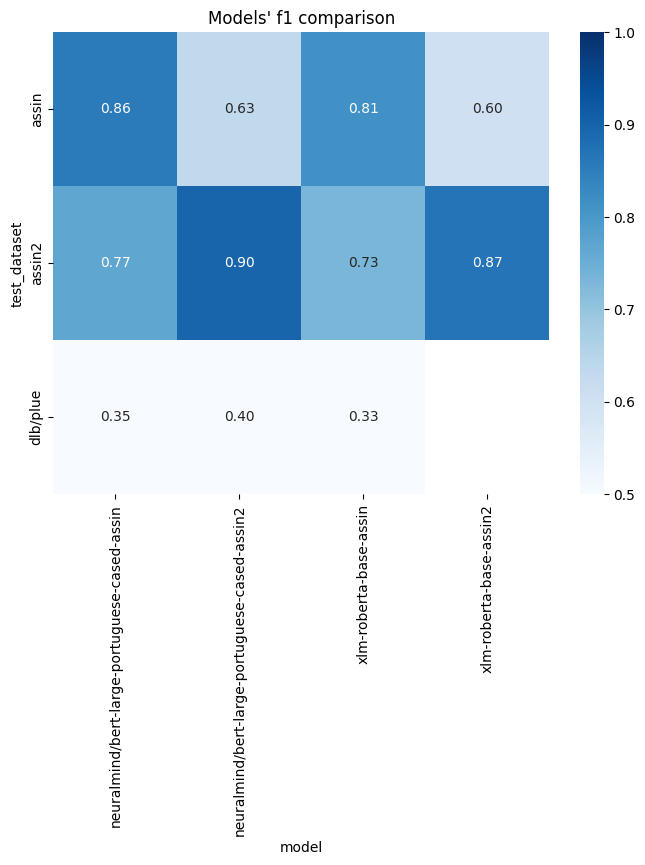

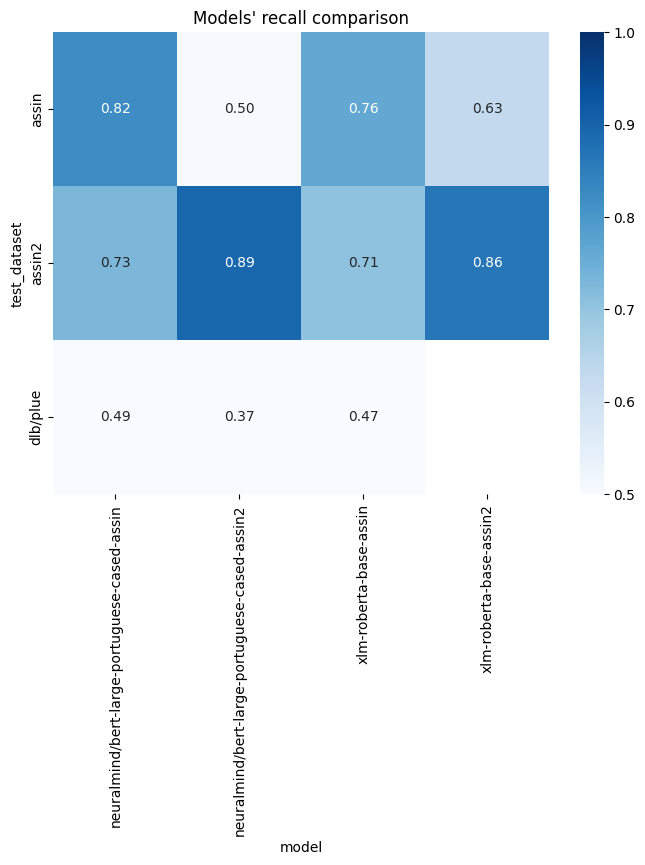

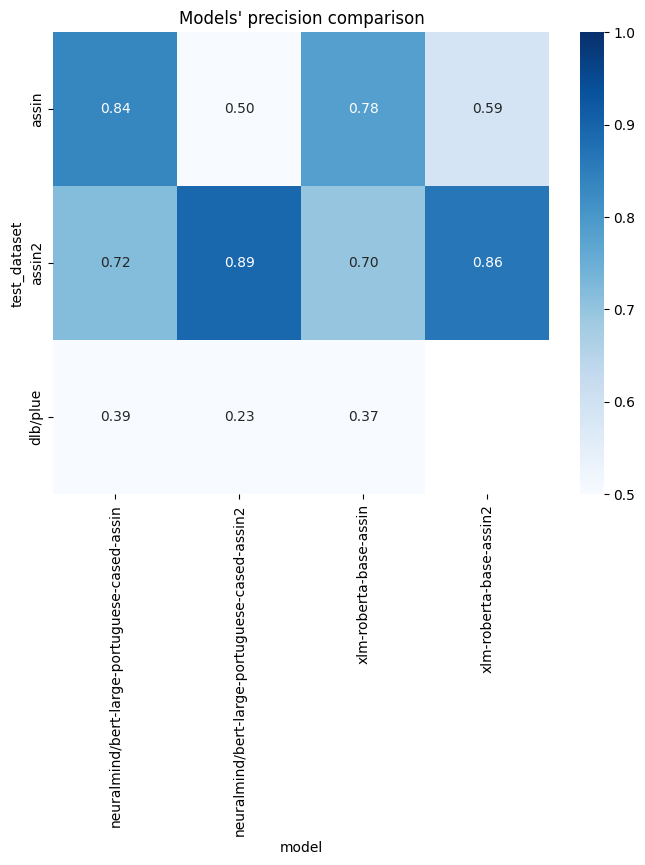

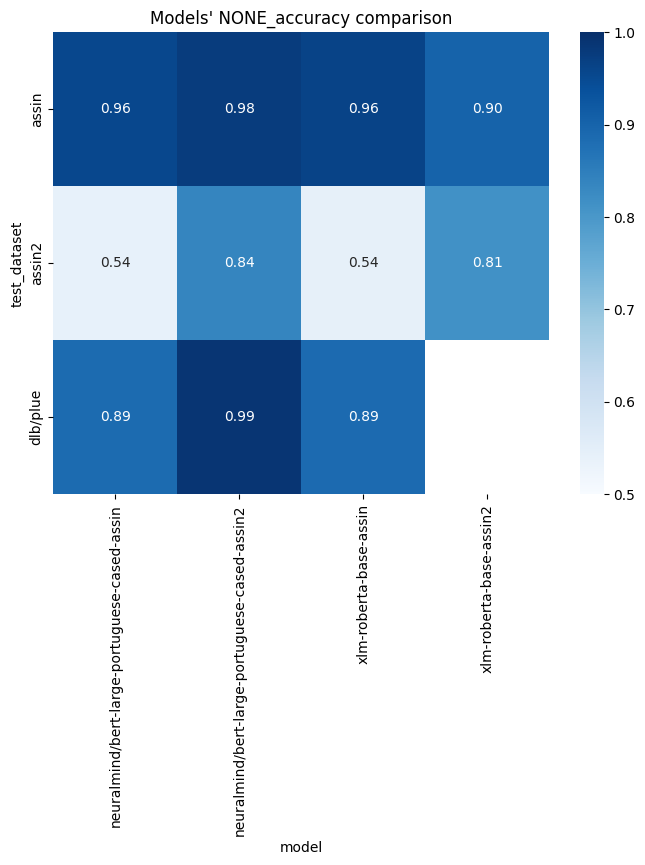

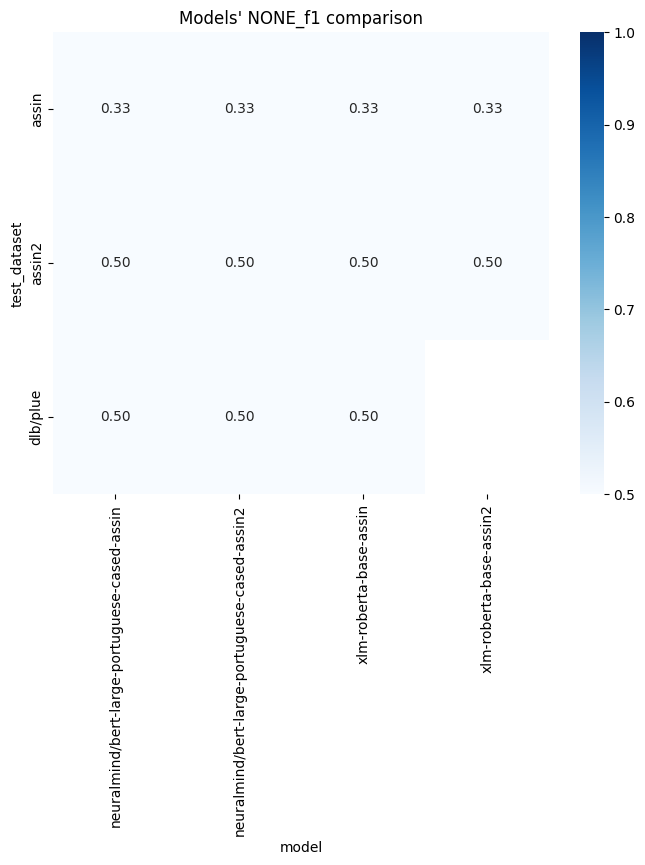

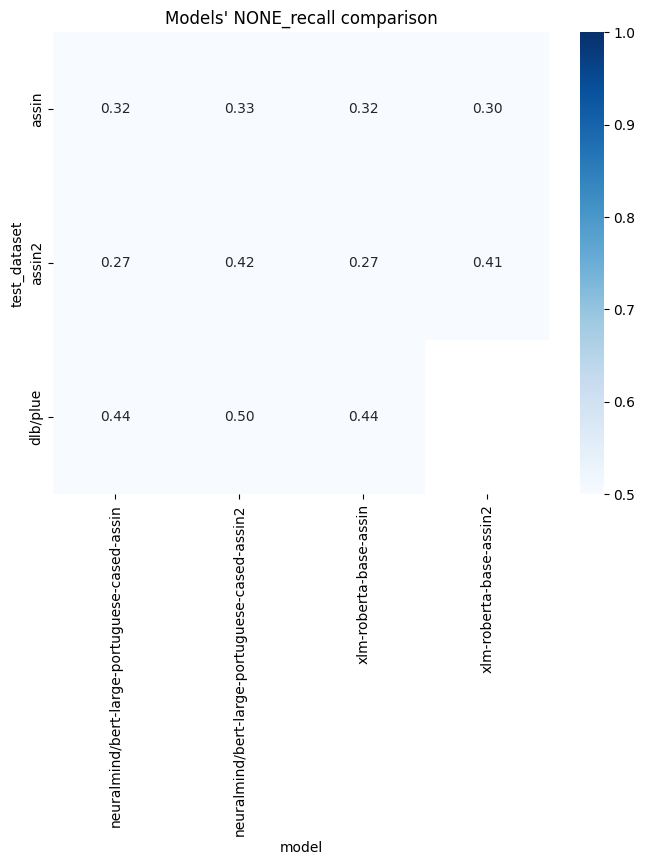

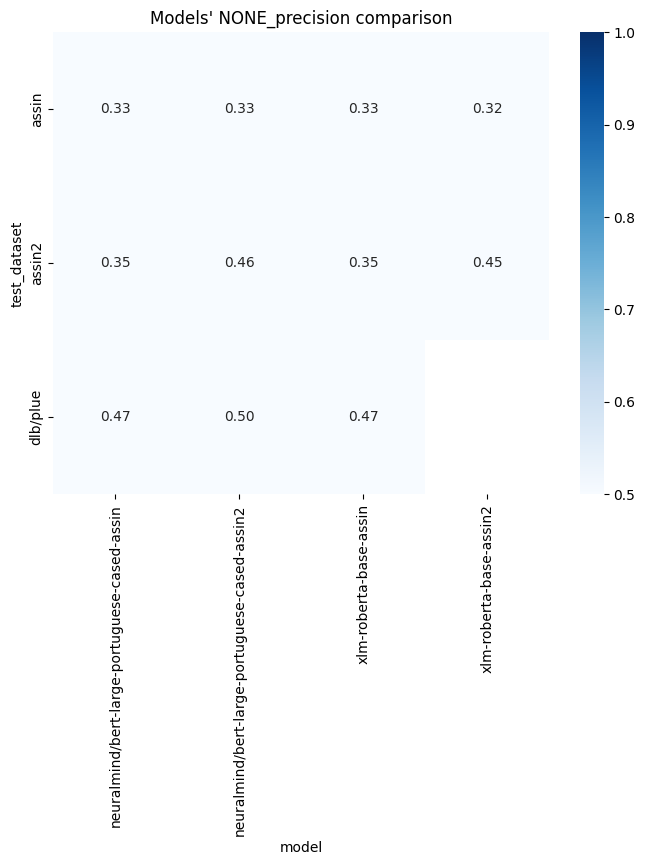

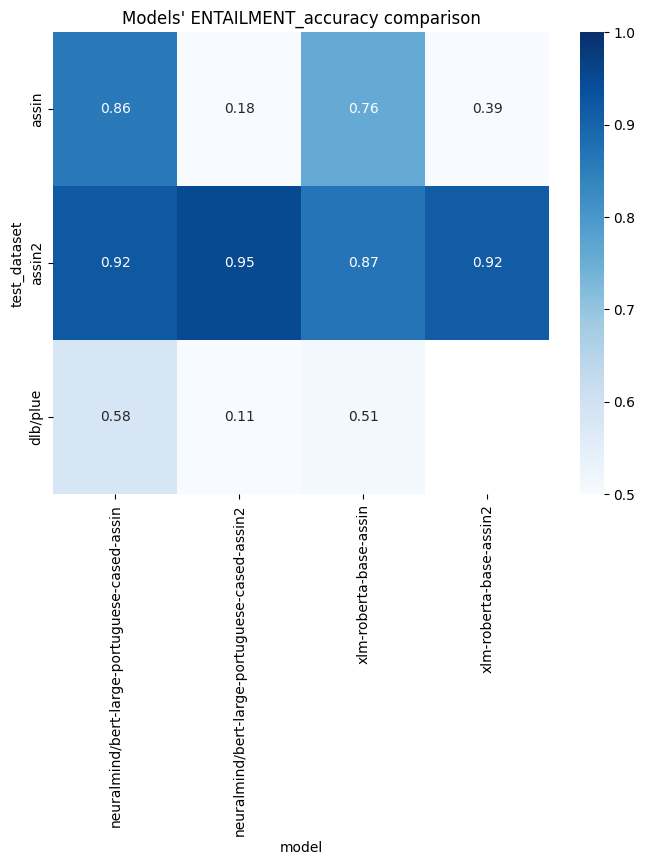

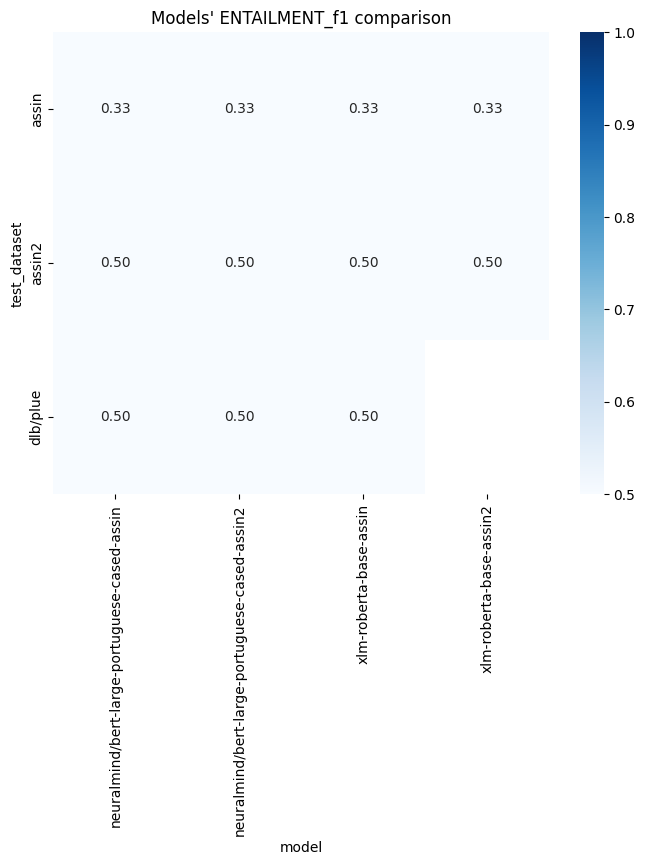

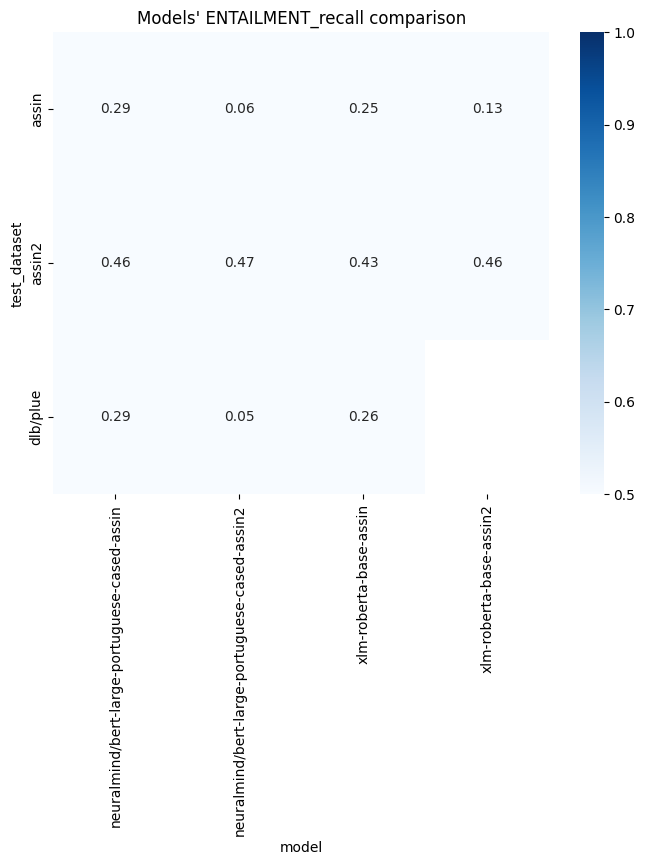

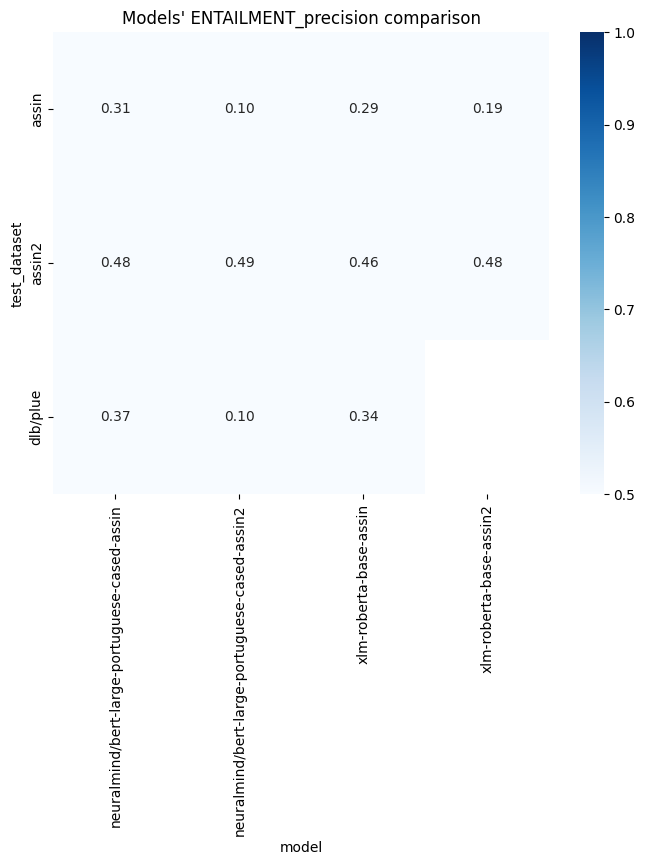

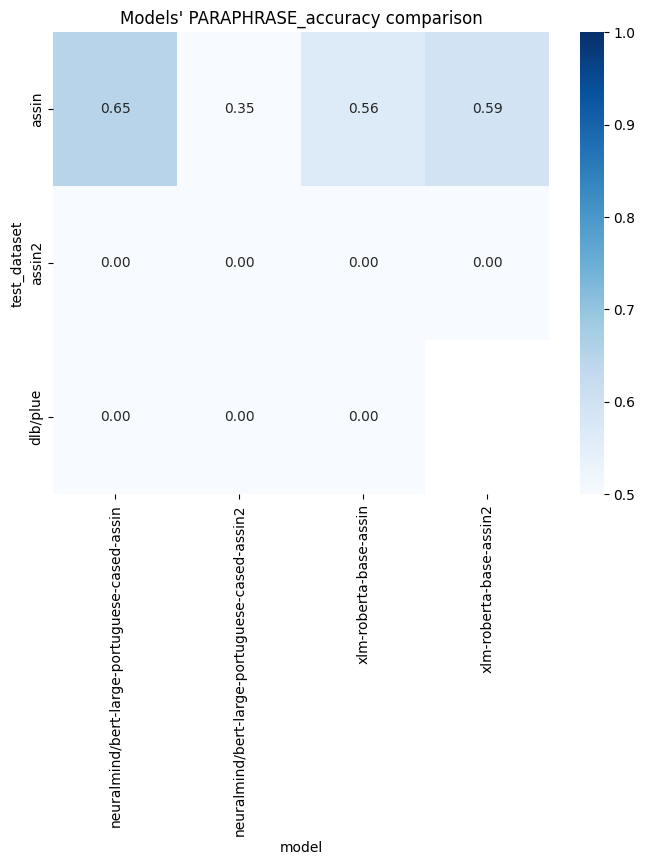

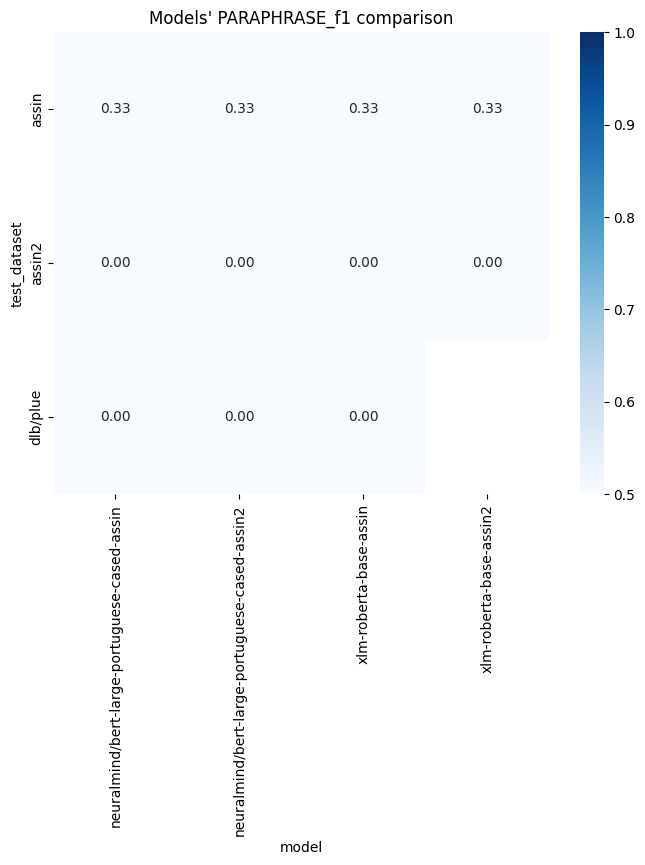

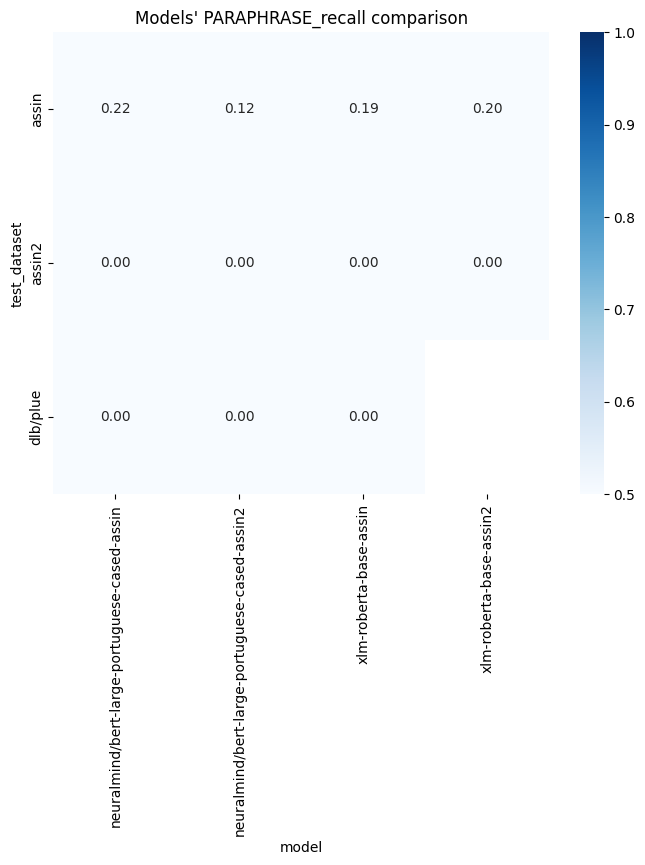

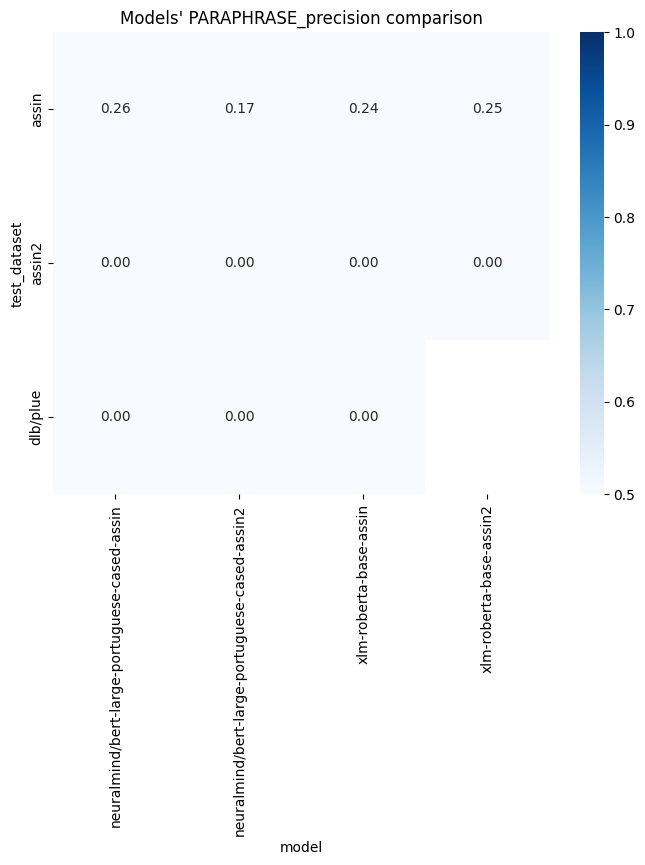

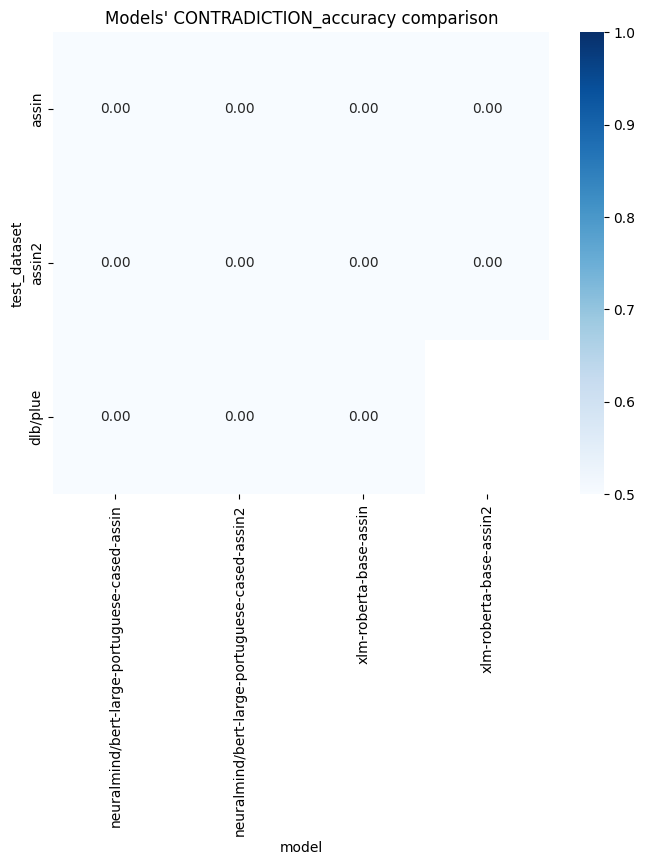

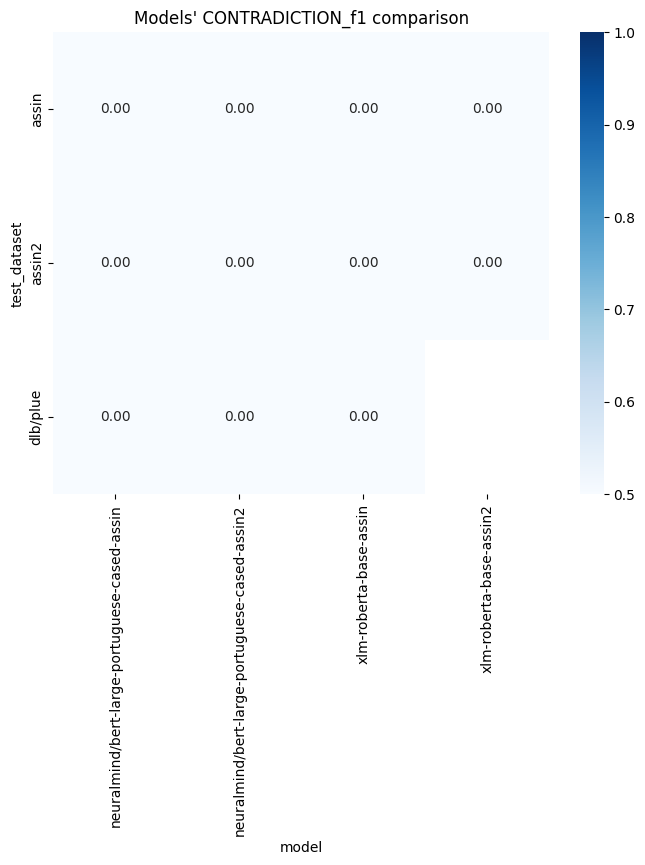

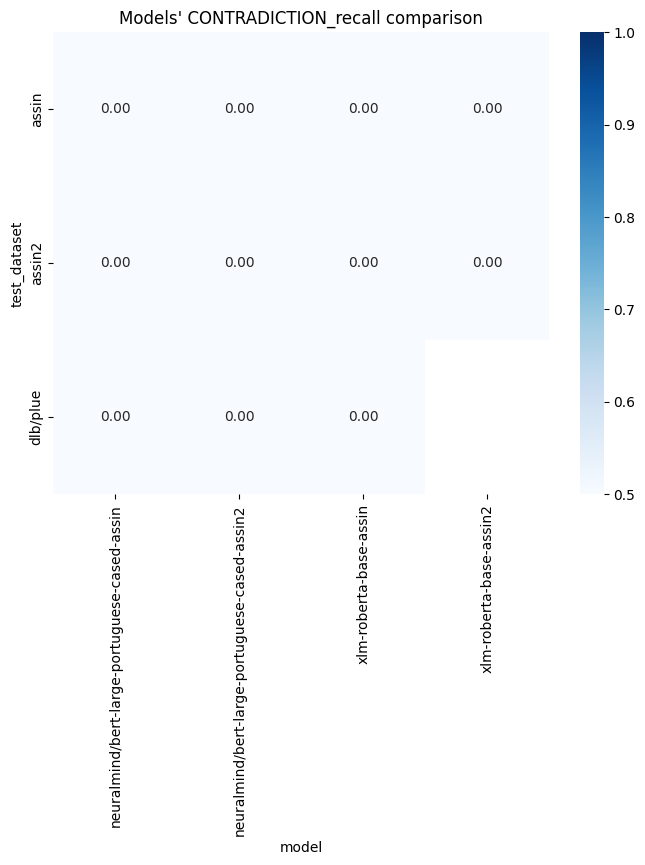

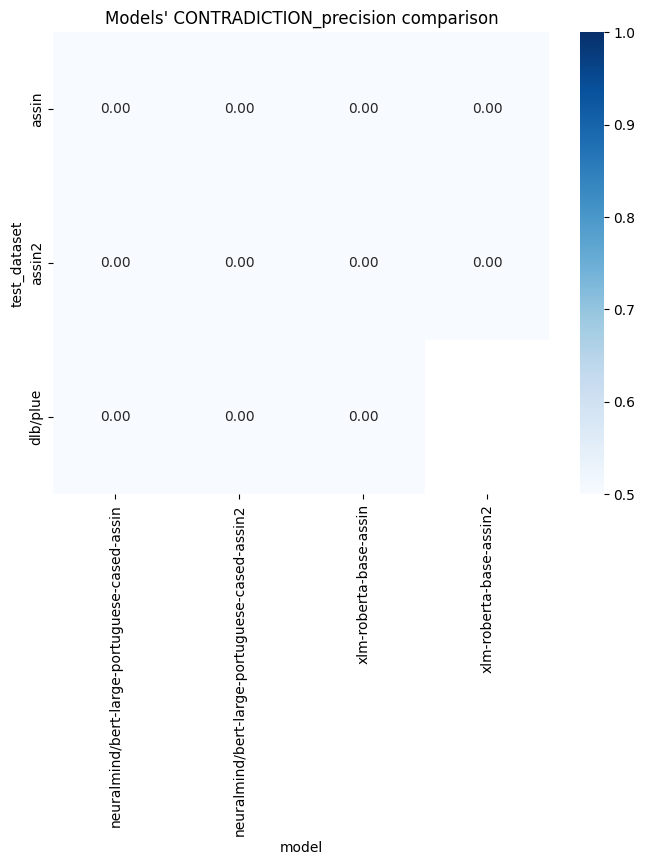

In [374]:
metrics_df["model"] = metrics_df["model_name"] + '-' + metrics_df["train_dataset"]
metrics_to_see.extend([label + '_' + metric for label in labels for metric in metrics_to_see])

for metric in metrics_to_see:
    plot_models_benchmark_results(metrics_df, metric)


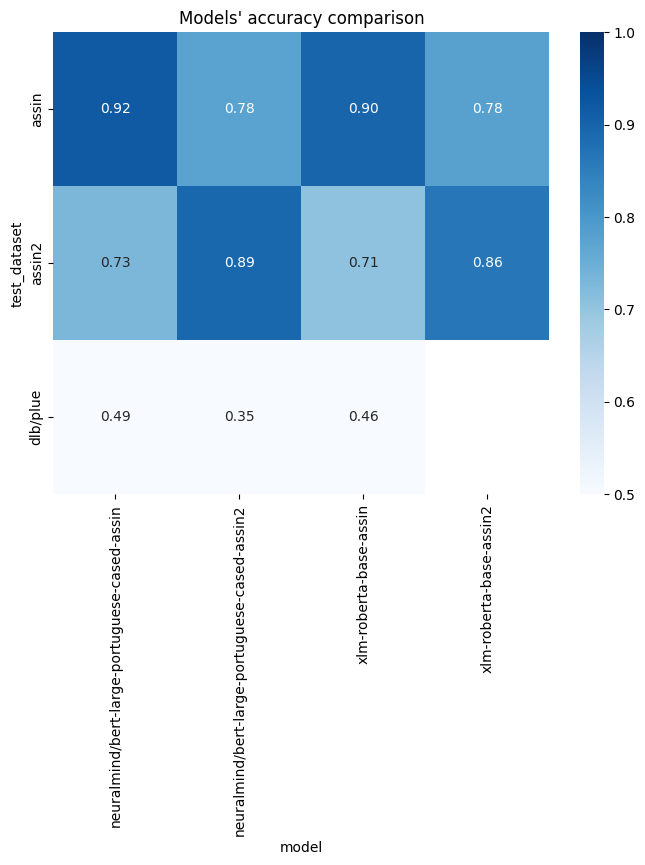

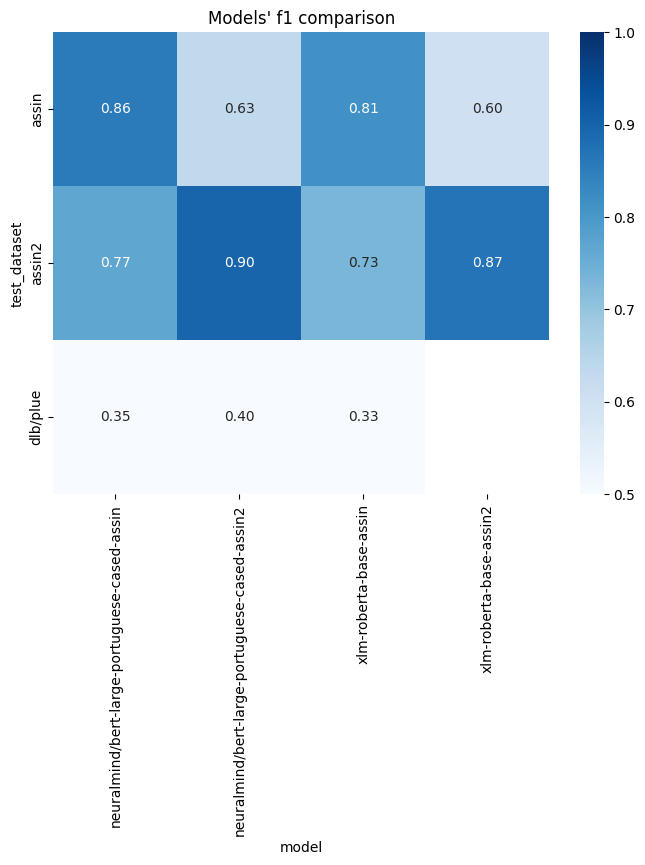

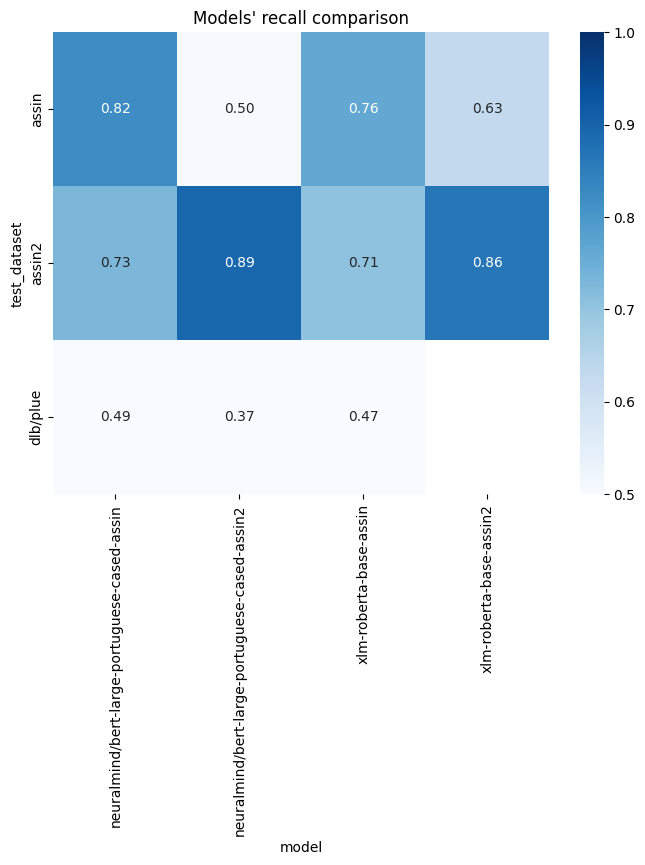

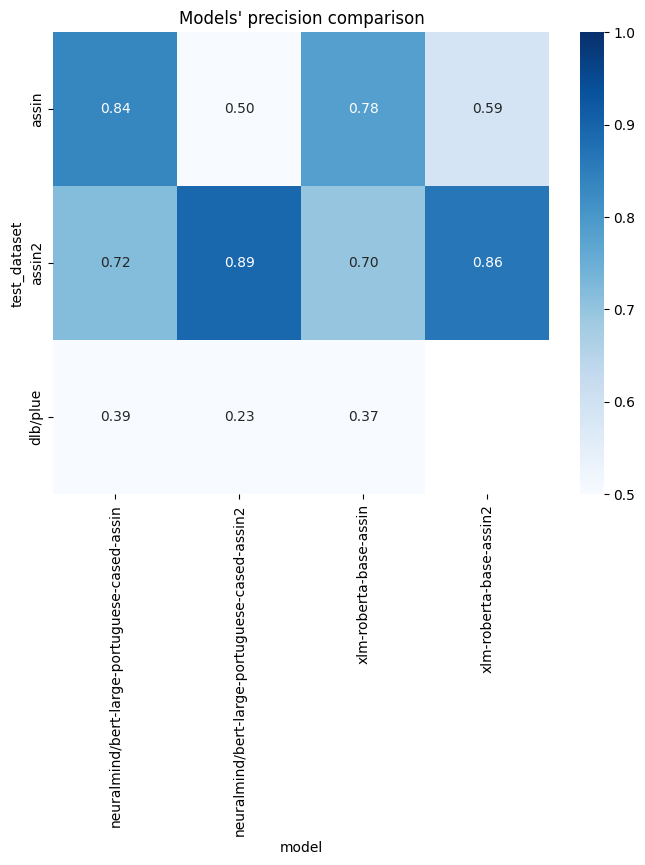

In [375]:
metrics_df["model"] = metrics_df["model_name"] + '-' + metrics_df["train_dataset"]
for metric in ['accuracy', 'f1', 'recall', 'precision']:
    plot_models_benchmark_results(metrics_df, metric)